# Analyze Glacier Changes by Watershed
This notebook provides an example of how to plot glacier changes (i.e., glacier mass, glacier area, and fixed glacier runoff) for various Shared Socioeconomic Pathways (SSPs) by watershed. These datasets used in this notebook can be downloaded from https://nsidc.org/data/hma2_ggp/versions/1 or you can create your own by running PyGEM and post-processing the script that aggregates individual glacier runs to regional data consistent with NSIDC standards.

## Input data
Specify the following including the regions, SSPs, and variables you want to process. <b>Remember to specify the filepath to where your regional files are! You also need a watershed file!</b>

In [1]:
regions = [11]
# regions = [13,14,15]
scenarios = ['ssp126', 'ssp245', 'ssp370', 'ssp585']
vns = ['mass_annual', 'area_annual', 'runoff_fixed_monthly']
# vns = ['mass_annual']
agg_fp = '/Users/drounce/Documents/HiMAT/Output/simulations_aggregated/'
normyear = 2000

group_dict_fullfn = '/Users/drounce/Documents/HiMAT/qgis_datasets/rgi60_watershed_dict.csv'
group_cn = 'watershed'

group_min_glaciers = 50 # only include a given group if there is a critical number

merge_hma = True # option to merge HMA together (useful for watersheds or other groups that span multiple regions)

plot_norm = True # option to plot normalized figures or not

debug = True # Set True for extra print statements to check correct

## Import Packages

In [2]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.ndimage import uniform_filter
import xarray as xr

try:
    import pygem
except:
    sys.path.append(os.getcwd() + '/../PyGEM/')
import pygem.pygem_modelsetup as modelsetup

## Dictionaries to support processing

In [3]:
ds_vn_dict = {'mass_annual':'glac_mass_annual',
              'area_annual':'glac_area_annual',
              'runoff_fixed_monthly':'glac_runoff_fixed_monthly'}
scenario_colordict = {'ssp119':'#081d58', 
                      'ssp126':'#1d91c0', 
                      'ssp245':'#7fcdbb', 
                      'ssp370':'#F47A20', 
                      'ssp585':'#ED2024'}
rgi_reg_dict = {'all':'Global',
                'global':'Global',
                1:'Alaska',
                2:'W Canada & US',
                3:'Arctic Canada North',
                4:'Arctic Canada South',
                5:'Greenland Periphery',
                6:'Iceland',
                7:'Svalbard',
                8:'Scandinavia',
                9:'Russian Arctic',
                10:'North Asia',
                11:'Central Europe',
                12:'Caucasus & Middle East',
                13:'Central Asia',
                14:'South Asia West',
                15:'South Asia East',
                16:'Low Latitudes',
                17:'Southern Andes',
                18:'New Zealand',
                19:'Antarctic & Subantarctic'
                }
scenario_namedict = {'rcp26':'RCP2.6',
                     'rcp45':'RCP4.5',
                     'rcp85':'RCP8.5',
                     'ssp119':'SSP1-1.9',
                     'ssp126':'SSP1-2.6',
                     'ssp245':'SSP2-4.5',
                     'ssp370':'SSP3-7.0',
                     'ssp585':'SSP5-8.5'}

## Load group dictionary

In [4]:
# Group Dictionary
group_csv = pd.read_csv(group_dict_fullfn)
group_dict = dict(zip(group_csv.RGIId, group_csv[group_cn]))

## Process group data

In [5]:
for region in regions:
    
    for nvn, vn in enumerate(vns):
        print(vn)
        # Filepath
        ds_fp = agg_fp + '/' + vn + '/' + str(region) + '/'
        # Dataset variable name
        ds_vn = ds_vn_dict[vn]
        
        for nscenario, scenario in enumerate(scenarios):
            # Filenames (lists enable batches which are used for runoff)
            ds_fns = []
            ds_fns_int = []
            for i in os.listdir(ds_fp):
                if str(region) in i and vn in i and scenario in i:
                    ds_fns.append(i)
                    if 'Batch' in i:
                        ds_fns_int.append(int(i.split('-')[-2]))
            
            # Sort filenames
            if len(ds_fns_int) > 0:
                ds_fns = [x for _,x in sorted(zip(ds_fns_int, ds_fns))]
                    
            # Load data (aggregate if necessary)
            for nfn, ds_fn in enumerate(ds_fns):
                if nfn == 0:
                    ds = xr.open_dataset(ds_fp + ds_fn)
                else:
                    ds_batch = xr.open_dataset(ds_fp + ds_fn)
                    ds = xr.concat((ds, ds_batch), dim='glacier')
        
            
            
            if nvn + nscenario == 0:
                glacno_list = [x.split('-')[1] for x in ds.RGIId.values]
                main_glac_rgi_reg = modelsetup.selectglaciersrgitable(glac_no=glacno_list)
                main_glac_rgi_reg[group_cn] = main_glac_rgi_reg.RGIId.map(group_dict)
            
                # unique groups
                groups_unique = list(main_glac_rgi_reg[group_cn].unique())
                groups_count = {}
                groups_idxs = {}
                for group in groups_unique:
                    main_glac_rgi_group = main_glac_rgi_reg.loc[main_glac_rgi_reg[group_cn] == group]
                    if main_glac_rgi_group.shape[0] > group_min_glaciers:
                        groups_count[group] = main_glac_rgi_group.shape[0]
                        groups_idxs[group] = list(main_glac_rgi_group.index.values)
                groups_unique = list(groups_count.keys())
                    
            # Get time series for each group and GCM
            for ngroup, group in enumerate(groups_unique):
                ds_vn_values = ds[ds_vn].values
                ds_vn_values_group = ds_vn_values[:,groups_idxs[group],:].sum(1)

                if ngroup == 0:
                    groups_vn_values = ds_vn_values_group[np.newaxis,:,:]
                else:
                    groups_vn_values = np.concatenate((groups_vn_values, ds_vn_values_group[np.newaxis,:,:]), axis=0)

            # Create new xarray dataset based on groups
            ds_group = ds.copy()
            # create new variable
            ds_vn_group = ds_vn.replace('glac','group')
            ds_group[ds_vn_group] = ds_group[ds_vn]
            # drop the glacier variable
            ds_group = ds_group[ds_vn_group].sel(glacier=1, drop=True).to_dataset()
            # add back attributes that were lost in conversion to data array above
            ds_group.attrs = ds.attrs
            # create new coordinate for group
            ds_group['group'] = groups_unique
            # save data array that expands the dimension of the variables to include groups
            ds_group_array = ds_group[ds_vn_group].expand_dims(group=groups_unique)
            # update dataset variable with the data array
            ds_group[ds_vn_group] = ds_group_array
            # update the values
            ds_group[ds_vn_group].values = groups_vn_values

            # Export aggregated dataset
            if 'Batch' in ds_fn:
                # remove Batch from filename since now its aggregated
                ds_group_fn = ds_fn.replace('glac', group_cn).split('-')[0] + '-' + ds_fn.split('-')[1] + '.nc'
            else:
                ds_group_fn = ds_fn.replace('glac', group_cn)
            ds_group_fp = agg_fp + group_cn + '/' + vn + '/' + str(region).zfill(2) + '/'
            if not os.path.exists(ds_group_fp):
                os.makedirs(ds_group_fp)
            ds_group.to_netcdf(ds_group_fp + ds_group_fn)

mass_annual
3925 glaciers in region 11 are included in this model run: ['00001', '00002', '00003', '00004', '00005', '00006', '00007', '00008', '00009', '00010', '00011', '00012', '00013', '00014', '00015', '00016', '00017', '00018', '00019', '00020', '00021', '00022', '00023', '00024', '00025', '00026', '00027', '00028', '00029', '00030', '00031', '00032', '00033', '00034', '00035', '00036', '00037', '00038', '00039', '00040', '00041', '00042', '00043', '00044', '00045', '00046', '00047', '00048', '00049', '00050'] and more
This study is focusing on 3925 glaciers in region [11]
area_annual
runoff_fixed_monthly


In [6]:
ds_group

<xarray.Dataset>
Dimensions:                     (group: 4, model: 12, time: 1212)
Coordinates:
    Climate_Model               (model) object 'BCC-CSM2-MR' ... 'NorESM2-MM'
  * time                        (time) datetime64[ns] 2000-01-01 ... 2100-12-01
  * group                       (group) <U6 'Danube' 'Rhine' 'Po' 'Rhone'
Dimensions without coordinates: model
Data variables:
    group_runoff_fixed_monthly  (group, model, time) float64 0.0 0.0 ... 0.0
Attributes:
    Region:       11 - Central Europe
    source:       PyGEMv0.1.0
    institution:  Carnegie Mellon University
    history:      Created by David Rounce (drounce@cmu.edu) on September 11 2021
    references:   doi:10.3389/feart.2019.00331 and doi:10.1017/jog.2019.91
    Conventions:  CF-1.9
    featureType:  timeSeries

## Merge High Mountain Asia, if included
Regions 13, 14, 15 comprise High Mountain Asia, but the region boundaries often do not line up well with group delineations (e.g., watersheds). Therefore, it's good practice to merge these regions together.

In [7]:
if merge_hma:
    if 13 in regions and 14 in regions and 15 in regions:
        for nvn, vn in enumerate(vns):
            for scenario in scenarios:

                ds_regions = None
                check_sum = 0
                for region in regions:
                    print(region, vn)
                    ds_group_fp = agg_fp + group_cn + '/' + vn + '/' + str(region).zfill(2) + '/'

                    # Find filename
                    for i in os.listdir(ds_group_fp):
                        if scenario in i:
                            ds_fn = i

                    # Open dataset and combine
                    ds = xr.open_dataset(ds_group_fp + ds_fn)
                    check_sum = check_sum + ds[ds_vn_group].values.sum()
                    if debug:
                        print(region, check_sum)
                    if ds_regions is None:
                        ds_regions = ds
                    else:
                        # Identify unique groups
                        groups_all = list(ds_regions.group.values)
                        groups_ind = list(ds.group.values)
                        groups_combined = list(set(groups_all + groups_ind))

                        for ngroup, group in enumerate(groups_combined):
                            # If only in all group, take values
                            if group in groups_all and not group in groups_ind:
                                if debug:
                                    print('group_existing:', group)
                                group_idx = groups_all.index(group)
                                ds_vn_values_group = ds_regions[ds_vn_group].values[group_idx, :, :]

                            # If only in new group, take values
                            elif group in groups_ind and not group in groups_all:
                                if debug:
                                    print('group_new:', group)
                                group_idx = groups_ind.index(group)
                                ds_vn_values_group = ds[ds_vn_group].values[group_idx, :, :]

                            # If in both groups, combine
                            elif group in groups_all and group in groups_ind:
                                if debug:
                                    print('group both:', group)
                                group_idx = groups_all.index(group)
                                ds_vn_values_group1 = ds_regions[ds_vn_group].values[group_idx, :, :]
                                group_idx = groups_ind.index(group)
                                ds_vn_values_group2 = ds[ds_vn_group].values[group_idx, :, :]
                                ds_vn_values_group = ds_vn_values_group1 + ds_vn_values_group2

                            # Aggregate groups
                            if ngroup == 0:
                                ds_vn_values = ds_vn_values_group[np.newaxis,:,:]
                            else:
                                ds_vn_values = np.concatenate((ds_vn_values, ds_vn_values_group[np.newaxis,:,:]), axis=0)

                        # Create new xarray dataset based on groups
                        ds_regions = ds.copy()
                        # drop the glacier variable
                        ds_regions = ds_regions[ds_vn_group].sel(group=groups_ind[0], drop=True).to_dataset()
                        # add back attributes that were lost in conversion to data array above
                        ds_regions.attrs = ds.attrs
                        ds_regions.attrs['Region'] = '13, 14, 15 - High Mountain Asia'
                        # create new coordinate for group
                        ds_regions['group'] = groups_combined
                        # save data array that expands the dimension of the variables to include groups
                        ds_regions_array = ds_regions[ds_vn_group].expand_dims(group=groups_combined)
                        # update dataset variable with the data array
                        ds_regions[ds_vn_group] = ds_regions_array
                        # update the values
                        ds_regions[ds_vn_group].values = ds_vn_values

                if debug:
                    print('check sum match:', check_sum, ds_regions[ds_vn_group].values.sum())

                # Export merged data
                ds_regions_fp = agg_fp + group_cn + '/' + vn + '/HMA/'
                if not os.path.exists(ds_regions_fp):
                    os.makedirs(ds_regions_fp)
                ds_regions_fn = 'HMA' + ds_fn[3:]
                ds_regions.to_netcdf(ds_regions_fp + ds_regions_fn)

        regions.append('HMA')
        for region in [13, 14, 15]:
            regions.remove(region)

        groups_unique = groups_combined

## Plot multi-gcm median regional data for scenarios

mass_annual
area_annual
runoff_fixed_monthly


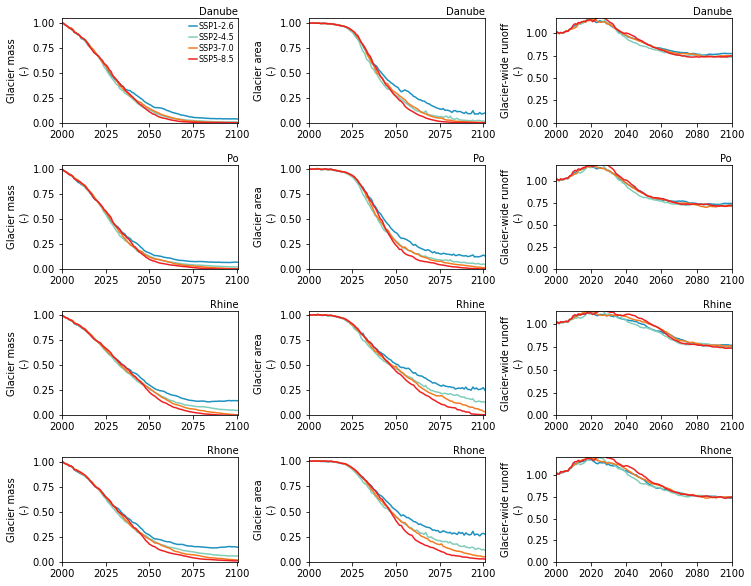

In [11]:
groups_unique = sorted(groups_unique)
for region in regions:
    
    fig, ax = plt.subplots(len(groups_unique), len(vns), squeeze=False, sharex=False, sharey=False, 
                       gridspec_kw = {'wspace':0.4, 'hspace':0.4})
    
    for nvn, vn in enumerate(vns):
        print(vn)
        
        # Filepath
        if type(region) is str:
            region_str = region
        else:
            region_str = str(region).zfill(2)
        ds_group_fp = agg_fp + group_cn + '/' + vn + '/' + region_str + '/'
        
        # Dataset variable name
        ds_vn = ds_vn_dict[vn].replace('glac', 'group')
        
        for ngroup, group in enumerate(groups_unique):
            for nscenario, scenario in enumerate(scenarios):
                # Filename
                for i in os.listdir(ds_group_fp):
                    if str(region) in i and vn in i and scenario in i:
                        ds_fn = i
     
                # Load data
                ds = xr.open_dataset(ds_group_fp + ds_fn)
                
                # Group idx
                group_idx = list(ds.group.values).index(group)

                # Aggregate data
                if 'annual' in ds_vn:
                    ds_med = ds[ds_vn].sel(group=group).median(dim='model')
                    ds_std = ds[ds_vn].sel(group=group).std(dim='model')
                    time_values = ds.year.values
                elif 'monthly' in ds_vn:
                    ds_med = ds[ds_vn].sel(group=group).resample(time='Y').sum('time').median('model')
                    ds_std = ds[ds_vn].sel(group=group).resample(time='Y').sum('time').std('model')
                    time_values = np.array([int(x) for x in pd.DatetimeIndex(ds_med.time.values).year])

                # Plot data
                normyear_idx = np.where(time_values == normyear)[0][0]
                ds_med_values = ds_med.values
                # Smooth runoff with 11-year running mean
                if 'runoff' in ds_vn:
                    ds_med_values = uniform_filter(ds_med_values, size=(11))

                if ngroup + nvn == 0:
                    label = scenario_namedict[scenario]
                else:
                    label = None

                if plot_norm:
                    ax[ngroup, nvn].plot(time_values, ds_med_values/ds_med_values[normyear_idx], 
                                         color=scenario_colordict[scenario], label=label)
                else:
                    ax[ngroup, nvn].plot(time_values, ds_med_values,
                                         color=scenario_colordict[scenario])

                # Bounds
                ax[ngroup, nvn].set_ylim(0)
                ax[ngroup, nvn].set_xlim(time_values[0], time_values[-1])
                
                # Add Labels
                try:
                    ylabel_wunits = ds[ds_vn].long_name + '\n(' + ds[ds_vn].units + ')'
                except:
                    ylabel_wunits = ds[ds_vn].long_name + '\n(' + ds[ds_vn].unit + ')'
                ylabel_norm = ds[ds_vn].long_name + '\n(-)'
                if plot_norm:
                    ax[ngroup, nvn].set_ylabel(ylabel_norm, size=10)
                else:
                    ax[ngroup, nvn].set_ylabel(ylabel_wunits, size=10)
                
                
                # Group label
                if nscenario == 0:
                    ax[ngroup, nvn].text(1, 1.01, group, size=10, horizontalalignment='right', 
                                         verticalalignment='bottom', transform=ax[ngroup,nvn].transAxes)
                    
            # Add legend
            if ngroup + nvn == 0:
                ax[ngroup,nvn].legend(loc='upper right', fontsize=8, ncol=1, columnspacing=0.5, labelspacing=0.25, 
                               handlelength=1, handletextpad=0.25, borderpad=0, frameon=False)
                
    fig.set_size_inches(4*len(vns), 2.5*len(groups_unique))
    fig.save_fig()
    plt.show()

## Considerations
- You can save this file by replacing plt.show() with fig.savefig()
- Some of the regional runoff files can get quite large. If this crashes your notebook, you can sum each batch of glaciers prior to concatenating the datasets to save space!